# COVID-19 in California: The Big Picture

## 1. Introduction
California has emerged as a hotspot for COVID-19 cases, leading to extensive, high-profile efforts to stem the virus' spread. However, policymakers continue to grapple with the Golden State's substantial size and diversity; sprawling metropolitan areas may see their hospitals straining for resources as deaths rise, while less populated regions could experience unnecessary economic devastation, given their relatively low mortality and infection rates. Therefore, the goal of this study is to provide a county-by-county overview of California's COVID-19 figures from April 1 to May 15, 2020, paying particular attention to the following questions:
* What is the relationship between the overall number of cases and the number of serious/fatal cases? 
* What is the relationship between the number of suspected cases (including symptomatic patients awaiting test results) and the number of actual cases?
* Can we accurately predict total deaths for a particular day, given the number of cases?

These questions may help us better understand how restrictions should be formed for each county, as well as an estimation for the medical severity of COVID-19 itself.

## 2. Data Source and Description
The data came in a CSV file and was acquired on May 16, 2020, from the [California Human Health and Services Agency data repository](https://healthdata.gov/dataset/california-covid-19-hospital-data-and-case-statistics). It contains the day-by-day count of COVID-19 cases, arranged by county and several other dimensions: whether the case required ICU treatment, whether the case was suspected or not, and the number of total deaths. This data was reported from April 1, 2020, to May 15, 2020 (totals before April 1 were unavailable). The following columns are available from this dataset (descriptions largely taken, with minor modifications, from the accompanying codebook, also found in the [GitHub repository](https://github.com/jrtran/DS_Blog_COVID)):
* County Name: County for which case statistics or hospital data were reported. 
* Most Recent Date: The date for which case statistics and hospital data were reported.
* Total Count Confirmed: Cumulative number of laboratory-confirmed positive COVID-19 cases as reported by local health departments.
* Total Count Deaths: Cumulative number of COVID-related deaths as reported by local health departments. It is expected that, to be counted, COVID is the cause of death or at least a contributing factor to the death. COVID-related deaths are also counted in "Positive Cases".
* COVID-19 Positive Patients: Number of laboratory-confirmed positive COVID-19 patients that are in hospitals TODAY.  This is not a cumulative number.  This includes emergency department, ICU, Telemetry, and Med/Surg patients, but not affiliated clinics or outpatient department patients.
* Suspected COVID-19 Positive Patients: Number of symptomatic patients, with tests for COVID-19 pending laboratory confirmation, that are in hospitals TODAY.  This is not a cumulative number.  This number includes emergency department, ICU, Telemetry, and Med/Surg patients, but not affiliated clinics or outpatient department patients.
* ICU COVID-19 Positive Patients: Number of laboratory-confirmed positive COVID-19 patients that are in hospital ICUs TODAY.  This is not a cumulative number.
* ICU COVID-19 Suspected Patients: Number of symptomatic patients, with tests for COVID-19 pending laboratory confirmation, that are in hospital ICUs TODAY.  The dashboard also reports difference and percentage change, compared to the prior day.




## 3. Setup and First Impressions
We'll begin by loading the required packages and data, making sure that everything shows up correctly.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
covid = pd.read_csv('covid19data.csv')
covid.head()

,County Name,Most Recent Date,Total Count Confirmed,Total Count Deaths,COVID-19 Positive Patients,Suspected COVID-19 Positive Patients,ICU COVID-19 Positive Patients,ICU COVID-19 Suspected Patients
0,Los Angeles,4/1/2020,3502.0,66.0,739.0,1332.0,335.0,220.0
1,San Bernardino,4/1/2020,245.0,5.0,95.0,196.0,39.0,52.0
2,Orange,4/1/2020,579.0,11.0,117.0,221.0,50.0,48.0
3,Riverside,4/1/2020,306.0,11.0,85.0,182.0,29.0,47.0
4,Sacramento,4/1/2020,299.0,8.0,53.0,138.0,20.0,33.0


In [3]:
covid.shape

(2654, 8)

In [4]:
covid.describe()

,Total Count Confirmed,Total Count Deaths,COVID-19 Positive Patients,Suspected COVID-19 Positive Patients,ICU COVID-19 Positive Patients,ICU COVID-19 Suspected Patients
count,2653.000000,2653.000000,2629.000000,2629.000000,2623.000000,2623.000000
mean,683.464757,26.524689,53.206923,31.321795,19.463210,5.884102
std,2742.827685,128.325401,216.573905,101.664574,73.118813,17.958283
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,53.000000,2.000000,2.000000,3.000000,1.000000,1.000000
75%,393.000000,11.000000,27.000000,22.000000,11.000000,4.000000
max,36317.000000,1755.000000,1962.000000,1350.000000,625.000000,220.000000


## 4. Wrangling
### A. Renaming
For convenience, since we know that our data deals with COVID-19 cases, we can simplify our column names.

In [5]:
covid.columns = ['County', 'Date', 'Total_Cases', 'Total_Deaths', 'Positive', 'Suspected', 'ICU_Positive', 'ICU_Suspected']

### B. Handling Missing Values
As we saw earlier, we seem to have some missing data. Let's take a closer look at the suspect columns:

In [6]:
covid.isnull().sum(axis = 0)

County            0
Date              0
Total_Cases       1
Total_Deaths      1
Positive         25
Suspected        25
ICU_Positive     31
ICU_Suspected    31
dtype: int64

We find out that `Total_Cases` and `Total_Deaths` are missing for only one row: Modoc County on 4/1/2020. We should replace our `NaN` values with 0 here, since there are 0 reported positive cases for that day, and the following days list the total number of cases and deaths as 0, as shown in the following code cell.

In [7]:
covid[covid.Total_Cases.isnull()]

,County,Date,Total_Cases,Total_Deaths,Positive,Suspected,ICU_Positive,ICU_Suspected
58,Modoc,4/1/2020,NaN,NaN,0.0,1.0,0.0,0.0


In [8]:
covid[covid.County == 'Modoc'].head()

,County,Date,Total_Cases,Total_Deaths,Positive,Suspected,ICU_Positive,ICU_Suspected
58,Modoc,4/1/2020,NaN,NaN,0.0,1.0,0.0,0.0
141,Modoc,4/3/2020,0.0,0.0,0.0,0.0,0.0,0.0
200,Modoc,4/4/2020,0.0,0.0,0.0,0.0,0.0,0.0
259,Modoc,4/5/2020,0.0,0.0,0.0,0.0,0.0,0.0
318,Modoc,4/6/2020,0.0,0.0,0.0,0.0,0.0,0.0


Next, let's look at the rows that have missing values for `ICU_Positive`. We discover that the resulting table accounts for all other missing values, and they seem to pop up for the same counties: Glenn, Alpine, Sierra, Sutter, and an unassigned region (cases that don't fall in any particular county).

In [9]:
covid[covid.ICU_Positive.isnull()].head(8) # remove .head(8) to see the entire table

,County,Date,Total_Cases,Total_Deaths,Positive,Suspected,ICU_Positive,ICU_Suspected
54,Unassigned,4/1/2020,50.0,1.0,NaN,NaN,NaN,NaN
55,Glenn,4/1/2020,2.0,0.0,NaN,NaN,NaN,NaN
56,Alpine,4/1/2020,1.0,0.0,NaN,NaN,NaN,NaN
57,Sierra,4/1/2020,0.0,0.0,NaN,NaN,NaN,NaN
60,Alpine,4/2/2020,1.0,0.0,NaN,NaN,NaN,NaN
103,Sierra,4/2/2020,0.0,0.0,NaN,NaN,NaN,NaN
108,Sutter,4/2/2020,10.0,1.0,0.0,0.0,NaN,NaN
113,Unassigned,4/2/2020,49.0,1.0,NaN,NaN,NaN,NaN


We can safely assume that for the named counties, all `NaN` values can be replaced by 0. For instance, in the time between 4/1/2020 and 4/8/2020, Alpine and Sierra Counties experienced no change in total cases/deaths, so the number of in-hospital patients would probably stay at 0. Sutter County saw its cases rise steadily, but there were no lab-confirmed hospital cases, implying that the new cases were non-hospital patients. Glenn County only has missing entries for 4/1/2020, the first day of reporting, and with only 2 confirmed cases, it's likely that those patients contracted COVID-19 before that day and thus were not part of the hospitals' daily count. Finally, since we are focusing on the county-by-county perspective, we will ignore those cases that went unassigned. We then clean our data as follows, making sure no more missing data remains:

In [10]:
covid = covid.fillna(0).drop(covid[covid.County == 'Unassigned'].index)
covid.isnull().sum()

County           0
Date             0
Total_Cases      0
Total_Deaths     0
Positive         0
Suspected        0
ICU_Positive     0
ICU_Suspected    0
dtype: int64

Taking another look at our dataframe's shape, we see that we've only lost less then 3% of our total rows by removing unassigned cases.

In [11]:
covid.shape

(2609, 8)

### C. Creating New Daily Columns

Based on the data codebook, we know that some of our columns describe disparate figures with respect to aggregation. `Total_Cases` and `Total_Deaths` are cumulative, but the other numeric variables are day-to-day counts. To deal with this, we can create day-to-day counts of new cases and deaths (e.g., today's total cumulative cases minus yesterday's cumulative cases). Here, we need to group by county to make sure we're not subtracting Los Angeles County's numbers from San Bernardino, for example.

In [12]:
covid['New_Cases'] = covid.Total_Cases - covid.groupby('County').Total_Cases.shift(1) # .shift(1) moves all values in the column "down" by one
covid['New_Deaths'] = covid.Total_Deaths - covid.groupby('County').Total_Deaths.shift(1)
covid.head()

,County,Date,Total_Cases,Total_Deaths,Positive,Suspected,ICU_Positive,ICU_Suspected,New_Cases,New_Deaths
0,Los Angeles,4/1/2020,3502.0,66.0,739.0,1332.0,335.0,220.0,NaN,NaN
1,San Bernardino,4/1/2020,245.0,5.0,95.0,196.0,39.0,52.0,NaN,NaN
2,Orange,4/1/2020,579.0,11.0,117.0,221.0,50.0,48.0,NaN,NaN
3,Riverside,4/1/2020,306.0,11.0,85.0,182.0,29.0,47.0,NaN,NaN
4,Sacramento,4/1/2020,299.0,8.0,53.0,138.0,20.0,33.0,NaN,NaN


We see that NaN values are produced, but this isn't an error! Since 4/1/2020 is the first day of reporting, we can't find new cases or deaths for that particular day. Also, we can't assume that the new case/death values are 0, since we don't have the previous cumulative totals. Once we move past 4/1/2020, the NaN values are gone.

In [13]:
covid.iloc[200:205, ]

,County,Date,Total_Cases,Total_Deaths,Positive,Suspected,ICU_Positive,ICU_Suspected,New_Cases,New_Deaths
203,Napa,4/4/2020,15.0,2.0,1.0,8.0,0.0,1.0,2.0,1.0
204,Nevada,4/4/2020,19.0,1.0,2.0,6.0,2.0,2.0,0.0,0.0
205,Orange,4/4/2020,781.0,15.0,143.0,213.0,70.0,45.0,68.0,2.0
206,Placer,4/4/2020,87.0,2.0,23.0,14.0,10.0,1.0,11.0,0.0
207,Plumas,4/4/2020,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We can also confirm that our columns are as expected by looking at one particular county, like Los Angeles County below.

In [14]:
covid[covid.County == 'Los Angeles'].head()

,County,Date,Total_Cases,Total_Deaths,Positive,Suspected,ICU_Positive,ICU_Suspected,New_Cases,New_Deaths
0,Los Angeles,4/1/2020,3502.0,66.0,739.0,1332.0,335.0,220.0,NaN,NaN
77,Los Angeles,4/2/2020,4040.0,79.0,818.0,1270.0,346.0,193.0,538.0,13.0
135,Los Angeles,4/3/2020,4566.0,91.0,962.0,1239.0,422.0,209.0,526.0,12.0
194,Los Angeles,4/4/2020,5275.0,117.0,1007.0,1190.0,449.0,181.0,709.0,26.0
253,Los Angeles,4/5/2020,5892.0,130.0,1094.0,1082.0,473.0,166.0,617.0,13.0


Now, let's deal with double-counted values. According to the data codebook, there are 3 columns that are subsets of other columns:
* `ICU_Positive` is included in `Positive`.
* `ICU_Suspected` is included in `Suspected`.
* `Total_Deaths` is included in `Total_Cases`.

Since we just created new daily totals for cases/deaths, we can also add the following column to the list:
* `New_Deaths` is included in `New_Cases`.

To remove this information overlap, we can simply subtract the "subset" columns from their "superset" counterparts.

In [15]:
covid['Total_Nonfatal_Cases'] = covid.Total_Cases - covid.Total_Deaths
covid['Non_ICU_Positive'] = covid.Positive - covid.ICU_Positive
covid['Non_ICU_Suspected'] = covid.Suspected - covid.ICU_Suspected
covid['New_Nonfatal_Cases'] = covid.New_Cases - covid.New_Deaths

Now, we can make a new dataframe that has only columns with non-duplicated values. We note that no information is actually lost (it's just transferred), but this helps to ensure that modelling and prediction proceed as expected.

In [16]:
covid_clean = covid.drop(columns = ['Total_Cases', 'New_Cases', 'Positive', 'Suspected'])
covid_clean.head()

,County,Date,Total_Deaths,ICU_Positive,ICU_Suspected,New_Deaths,Total_Nonfatal_Cases,Non_ICU_Positive,Non_ICU_Suspected,New_Nonfatal_Cases
0,Los Angeles,4/1/2020,66.0,335.0,220.0,NaN,3436.0,404.0,1112.0,NaN
1,San Bernardino,4/1/2020,5.0,39.0,52.0,NaN,240.0,56.0,144.0,NaN
2,Orange,4/1/2020,11.0,50.0,48.0,NaN,568.0,67.0,173.0,NaN
3,Riverside,4/1/2020,11.0,29.0,47.0,NaN,295.0,56.0,135.0,NaN
4,Sacramento,4/1/2020,8.0,20.0,33.0,NaN,291.0,33.0,105.0,NaN


### D. Handling Categorical Variables

The only categorical variable that we need to consider is the county. We first observe the number of counties:

In [17]:
len(covid.County.unique())

58

That's quite a few! We'll turn this categorical variable into dummy columns, in order to use the dataframe with models that require all-numeric inputs, such as certain gradient boosting algorithms. Otherwise, most regression and decision tree methods can handle categorical variables fairly well without this extensive dummifying.

In [18]:
covid_dummy = covid_clean.copy()
covid_dummy = pd.get_dummies(covid_dummy, columns = ['County'], drop_first = True)
covid_dummy.head()

,Date,Total_Deaths,ICU_Positive,ICU_Suspected,New_Deaths,Total_Nonfatal_Cases,Non_ICU_Positive,Non_ICU_Suspected,New_Nonfatal_Cases,County_Alpine,...,County_Sonoma,County_Stanislaus,County_Sutter,County_Tehama,County_Trinity,County_Tulare,County_Tuolumne,County_Ventura,County_Yolo,County_Yuba
0,4/1/2020,66.0,335.0,220.0,NaN,3436.0,404.0,1112.0,NaN,0,...,0,0,0,0,0,0,0,0,0,0
1,4/1/2020,5.0,39.0,52.0,NaN,240.0,56.0,144.0,NaN,0,...,0,0,0,0,0,0,0,0,0,0
2,4/1/2020,11.0,50.0,48.0,NaN,568.0,67.0,173.0,NaN,0,...,0,0,0,0,0,0,0,0,0,0
3,4/1/2020,11.0,29.0,47.0,NaN,295.0,56.0,135.0,NaN,0,...,0,0,0,0,0,0,0,0,0,0
4,4/1/2020,8.0,20.0,33.0,NaN,291.0,33.0,105.0,NaN,0,...,0,0,0,0,0,0,0,0,0,0


## 5. Answering the Questions
### A. Relating Overall Cases with Serious/Fatal Cases
Answering this question may help us to see exactly how serious COVID-19 is, both in terms of estimating its mortality rate (at least among hospital-admitted patients) and with regards to its potential to strain healthcare infrastructure by filling up intensive care unit (ICU) capacity. First, we can simply look at the overall percentage of lab-confirmed cases that led to death, making sure to use the latest date in the dataset (which will show the cumulative totals reported up to March 15, 2020):

In [104]:
covid_totals = covid[covid.Date == covid.Date[len(covid.Date)]][['Date', 'County','Total_Deaths', 'Total_Cases']] 
covid_totals['Death_Rate'] = covid_totals.Total_Deaths / covid_totals.Total_Cases
covid_totals.head() # remove .head() to see the entire table

,Date,County,Total_Deaths,Total_Cases,Death_Rate
2595,05/15/2020,Alameda,85.0,2289.0,0.037134
2596,05/15/2020,Alpine,0.0,1.0,0.000000
2597,05/15/2020,Amador,0.0,8.0,0.000000
2598,05/15/2020,Butte,0.0,22.0,0.000000
2599,05/15/2020,Calaveras,0.0,13.0,0.000000


Looking at this table is a bit strenuous, and it's difficult to get the big picture. We can instead use FIPS (Federal Information Processing Standard) codes to identify each county in California and gain access to Plotly's mapping functions. We'll read in a file that contains the FIPS codes for the whole country, then filter to only include counties in California (which has a FIPS code of 06).

In [105]:
fips = pd.read_excel('all-geocodes-v2016.xlsx', dtype = object, skiprows = 4)
pd.options.mode.chained_assignment = None # helps us avoid warnings when making new columns via chained functions

fips_ca = fips[(fips['State Code (FIPS)'] == '06') & (fips['County Code (FIPS)'] != '000')]
fips_ca['FIPS'] = fips_ca['State Code (FIPS)'] + fips_ca['County Code (FIPS)']

remove_county = lambda county: county.replace(' County', '') # truncate 'X County' to 'X' for later merging

fips_ca['County'] = fips_ca['Area Name (including legal/statistical area description)'].apply(remove_county)
fips_ca = fips_ca.loc[:, ['FIPS', 'County']]
fips_ca.head()

,FIPS,County
1394,06001,Alameda
1395,06003,Alpine
1396,06005,Amador
1397,06007,Butte
1398,06009,Calaveras


From here, we can join our COVID-19 dataset with this FIPS table.

In [106]:
fips_covid = fips_ca.merge(covid_totals, on = 'County')
fips_covid.head()

,FIPS,County,Date,Total_Deaths,Total_Cases,Death_Rate
0,06001,Alameda,05/15/2020,85.0,2289.0,0.037134
1,06003,Alpine,05/15/2020,0.0,1.0,0.000000
2,06005,Amador,05/15/2020,0.0,8.0,0.000000
3,06007,Butte,05/15/2020,0.0,22.0,0.000000
4,06009,Calaveras,05/15/2020,0.0,13.0,0.000000


Finally, we can use Plotly's interface to see the death rates by county, inspired by the examples [here](https://plotly.com/python/choropleth-maps/#united-states-choropleth-map). In the process, we also need to extract the counties from the GeoJSON object that are actually in California.

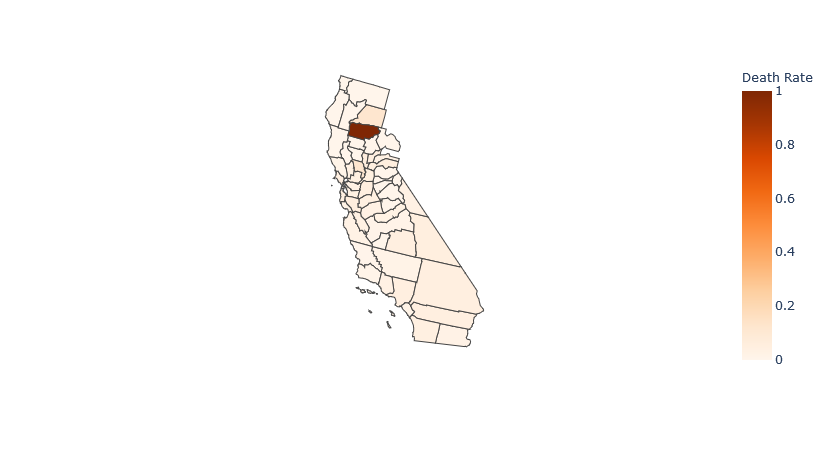

In [107]:
from urllib.request import urlopen
import json
with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    counties = json.load(response)

# extract California counties only
ca_counties_list = [county for county in counties['features'] if county['properties']['STATE'] == '06']
ca_counties =  {'type': 'FeatureCollection', 'features': ca_counties} # revert to a FeatureCollection object

import plotly.express as px

fig = px.choropleth(fips_covid, geojson = test, locations = fips_covid.County, 
                    color = 'Death_Rate', color_continuous_scale = 'oranges', 
                    featureidkey = 'properties.NAME',
                    scope = 'usa', labels = {'Death_Rate':'Death Rate'})
fig.update_geos(fitbounds = 'locations', visible=False)
fig.show()

The resulting map gives us some insight as to how COVID-19 affected California during these months. Most counties seem to experience relatively low death rates. The misisng counties apparent in the top-right corner of the map represent counties that have 0 reported cases and therefore 0 reported deaths.  